In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "cassandra"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 23
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,0,1,0.830325,0.618280,0.708783,0.849536,0.727794,0.872543,0.856707,base
1,cassandra,0,2,0.790698,0.624672,0.697947,0.804384,0.708028,0.836955,0.802508,base
2,cassandra,0,3,0.782051,0.524355,0.627787,0.758790,0.669453,0.771998,0.854701,base
3,cassandra,0,4,0.598930,0.427481,0.498886,0.745856,0.595216,0.612321,0.828767,base
4,cassandra,0,5,0.494118,0.617647,0.549020,0.725940,0.676024,0.507289,0.739919,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.546667,0.719298,0.621212,0.820513,0.740457,0.623253,0.762238,ecoselekt
1,cassandra,15,17,0.764706,0.747126,0.755814,0.869698,0.784150,0.824748,0.823009,ecoselekt
2,cassandra,15,18,0.606742,0.818182,0.696774,0.860188,0.777482,0.791590,0.738806,ecoselekt
3,cassandra,15,19,0.694915,0.828283,0.755760,0.815682,0.730105,0.792277,0.643564,ecoselekt
4,cassandra,15,20,0.631148,0.855556,0.726415,0.813586,0.711024,0.776203,0.590909,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.653333,0.859649,0.742424,0.886333,0.838659,0.772579,0.818182,best
1,cassandra,15,17,0.802326,0.793103,0.797688,0.919388,0.820845,0.889525,0.849558,best
2,cassandra,15,18,0.687500,0.833333,0.753425,0.908469,0.823323,0.856454,0.813433,best
3,cassandra,15,19,0.737288,0.878788,0.801843,0.882838,0.780424,0.883727,0.693069,best
4,cassandra,15,20,0.672269,0.888889,0.765550,0.871212,0.757455,0.860914,0.645455,best


(72, 11)


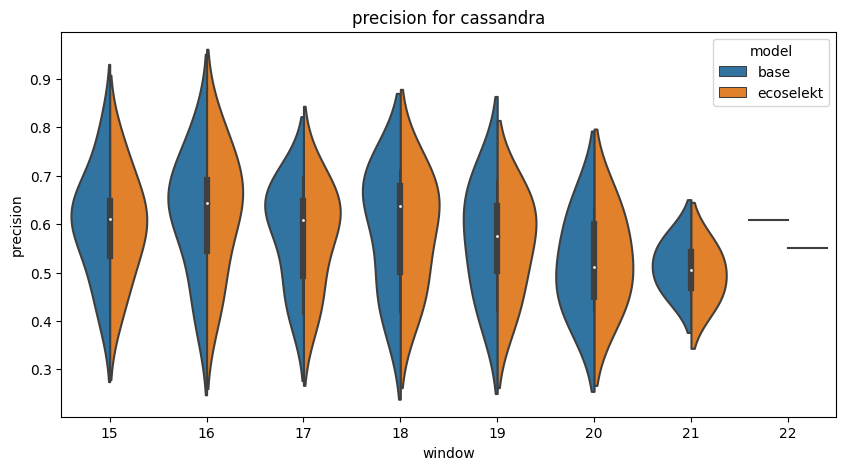

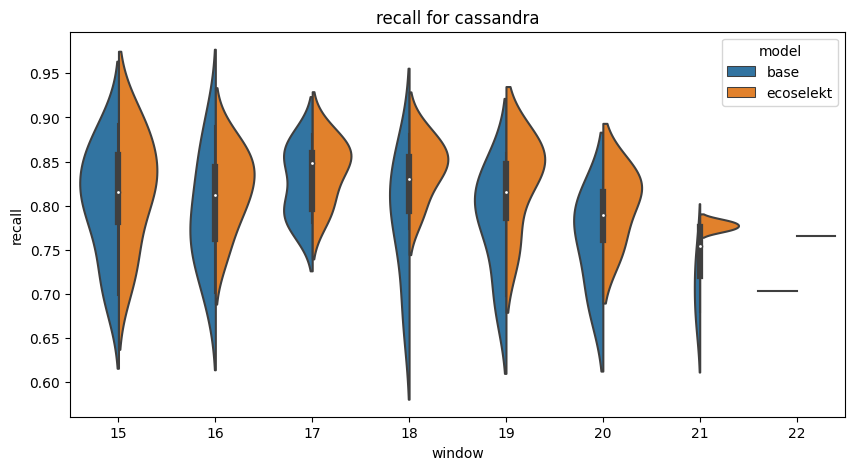

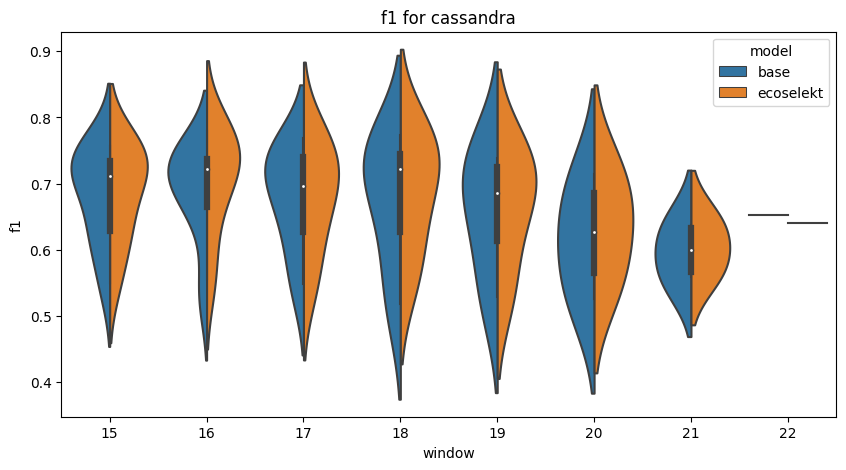

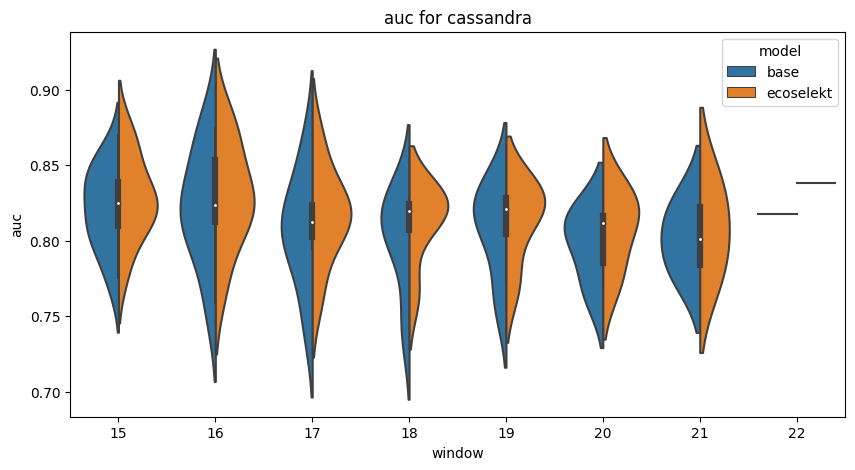

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


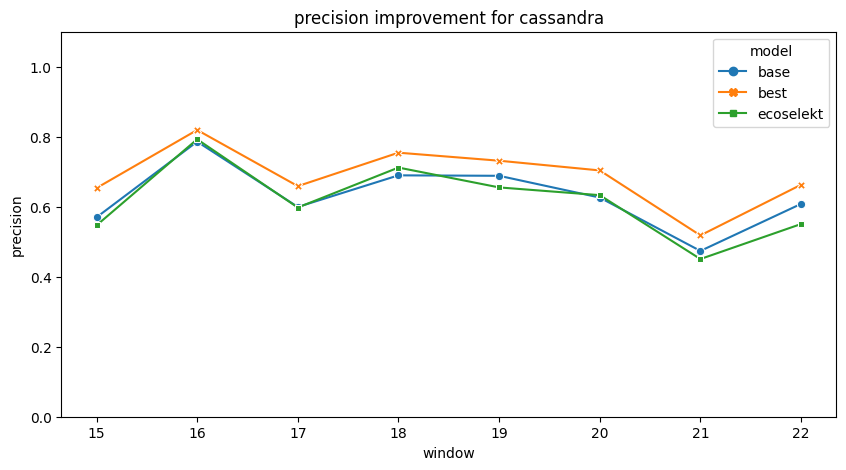

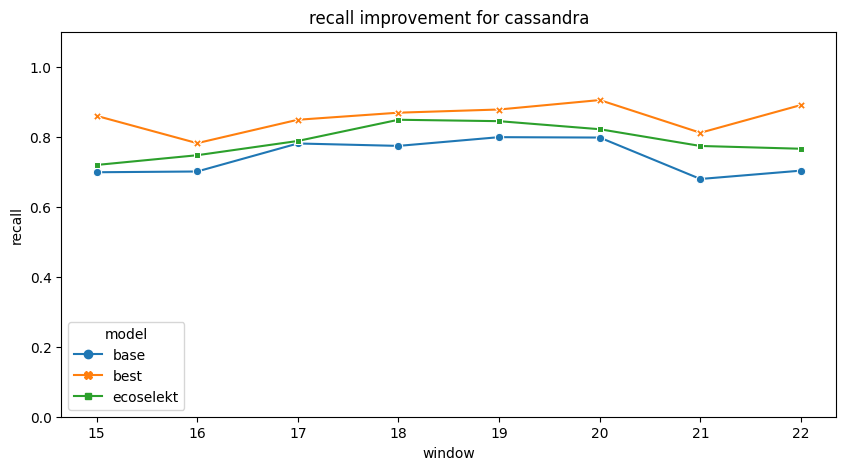

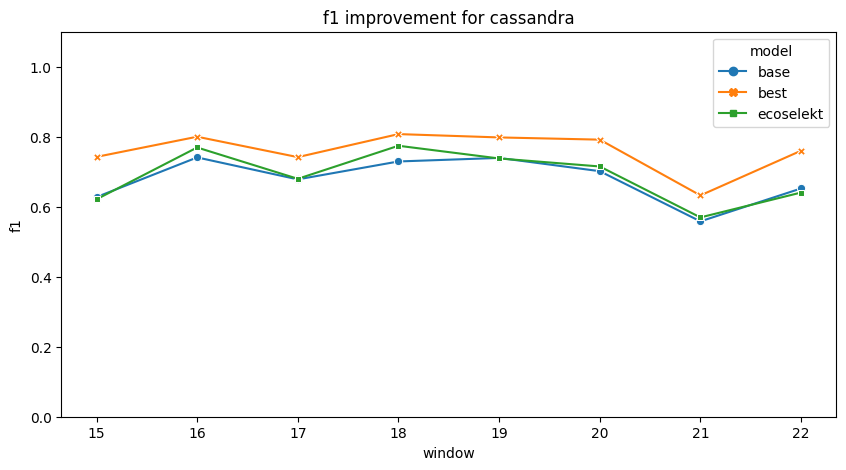

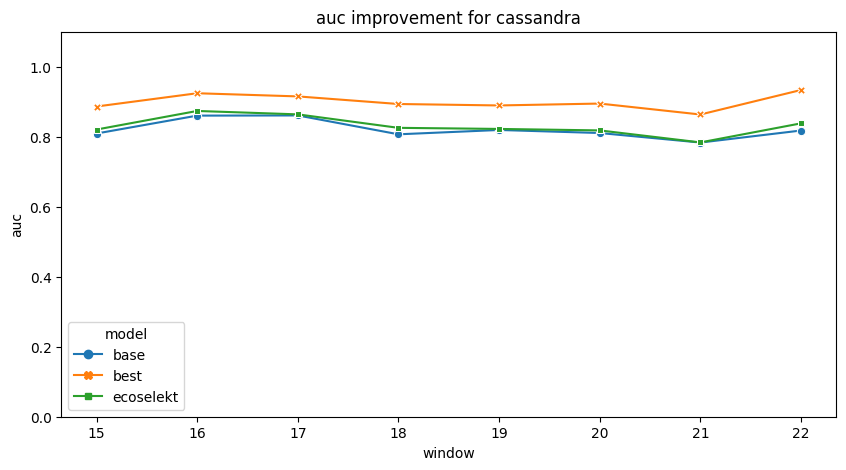

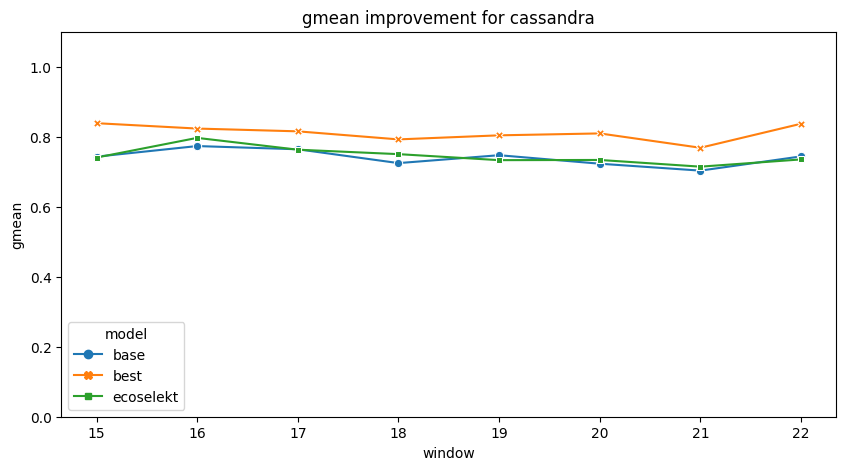

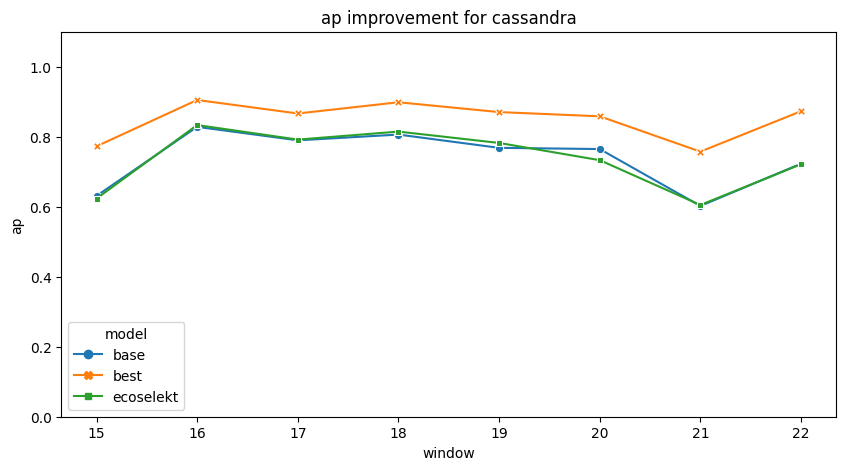

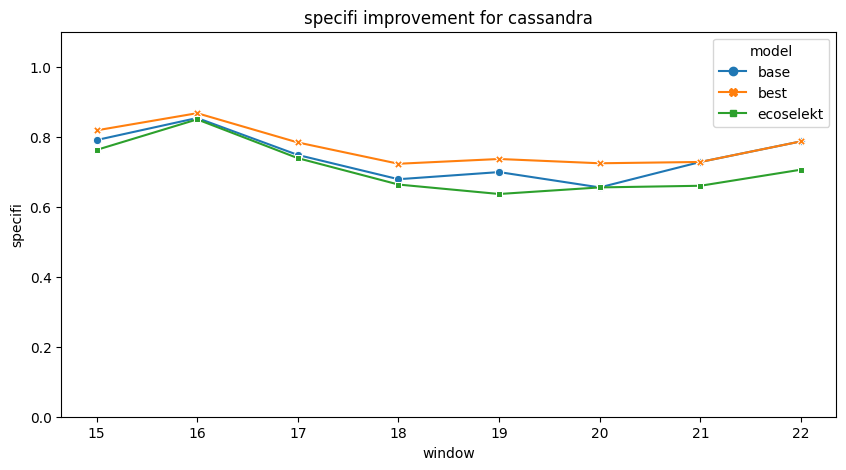

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

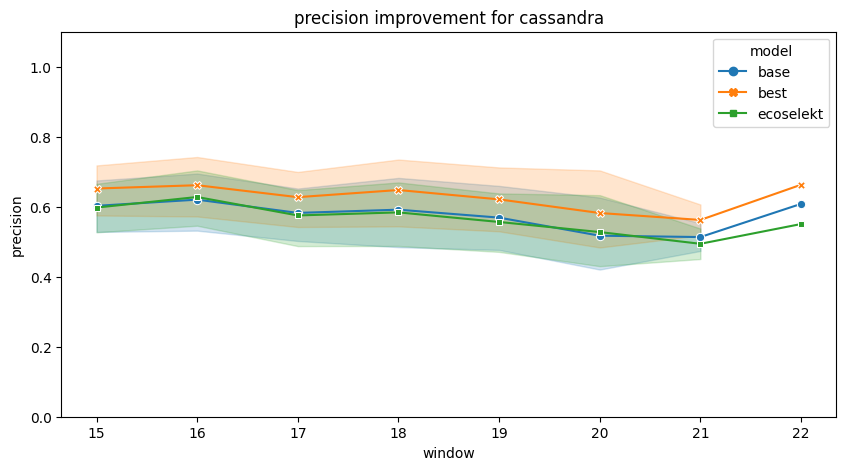

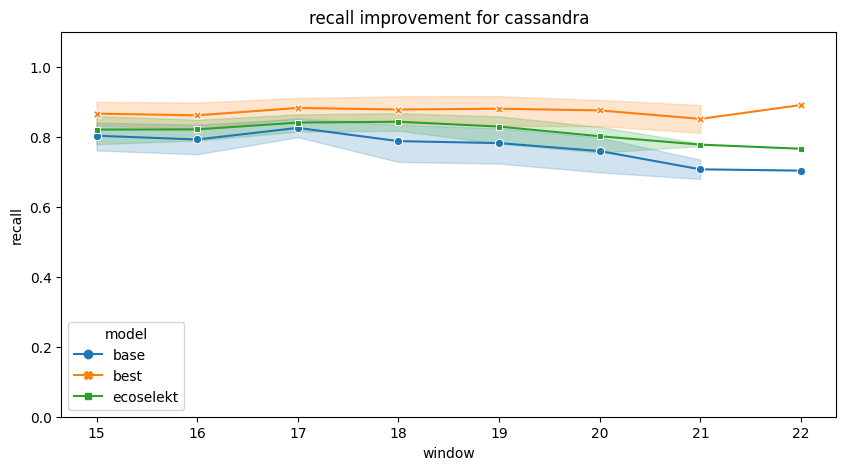

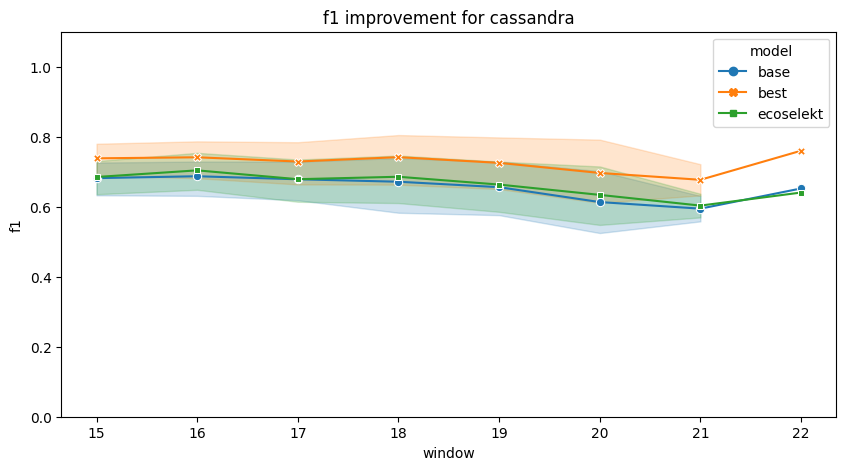

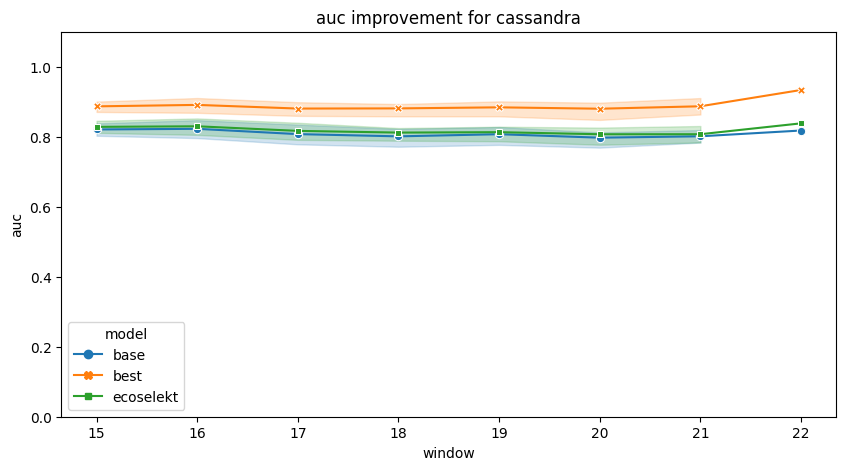

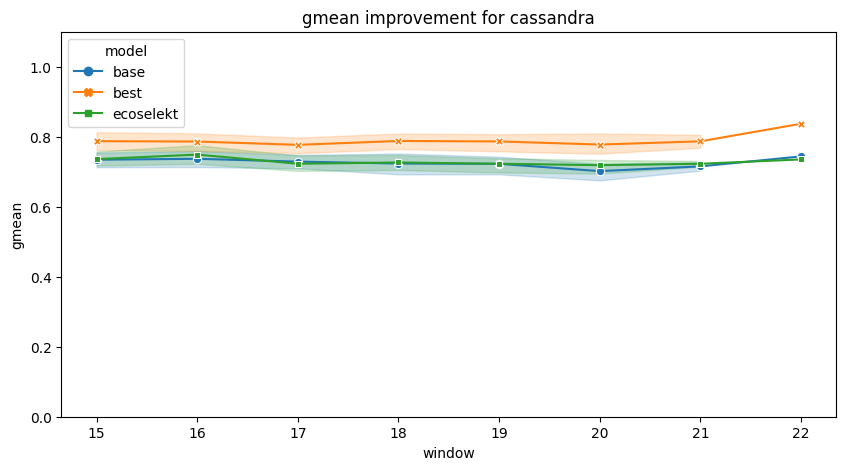

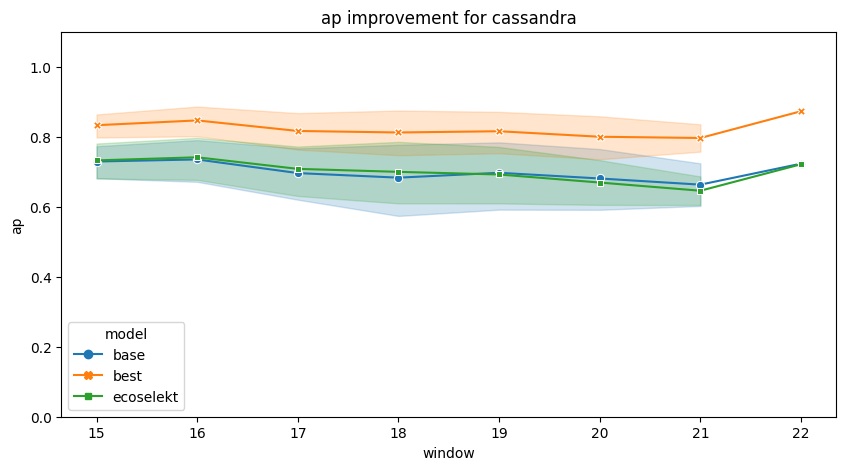

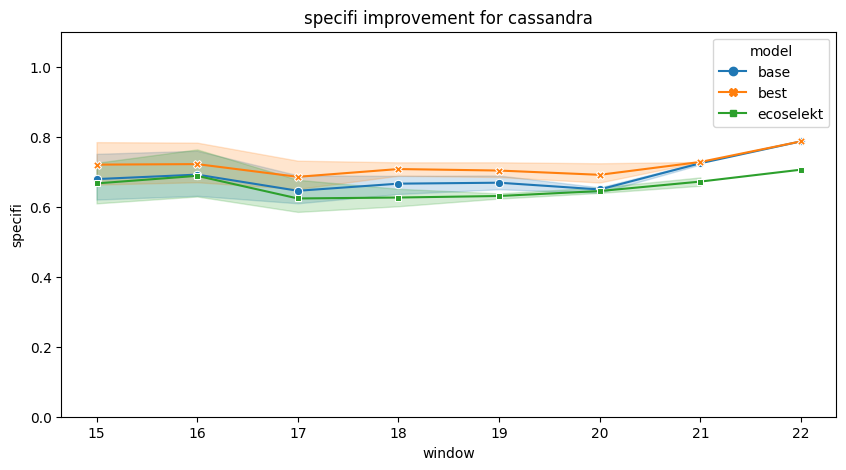

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.0078125
Wilcoxon test significance: True


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.0078125
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(7200, 4)


,commit_id,window,test_split,model_version
0,c489a4e37aeb46be7b91f740c22cb4d6feac57f5,15,16,15
1,618441b9776bf1da3dcda76ce20dd04734dfab59,15,16,15
2,a6678a273d61b4db54e0b7afeeab8b1b0f7d82a1,15,16,15
3,f7598815059bad05b6c6a4af53c8f5f5c8800a04,15,16,11
4,d93a580d73f733b5b40e768c5c838a219b552bde,15,16,15


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(42000, 4)


,commit_id,window,test_split,model_version
0,00748405bc374ee8f5ade4891a6a1445df072344,15,16,12
1,018e82b5eff17b50301a01069664ef37a4ae142f,15,16,8
2,01bc564bb2e89684b445f217a83c39f32113560a,15,16,9
3,01d81d27651c9608fa1344ea1ca769ea8ec4e4d6,15,16,12
4,03b4c2794c4c0f5e11ec9a24b52b523d8746fbb5,15,16,14


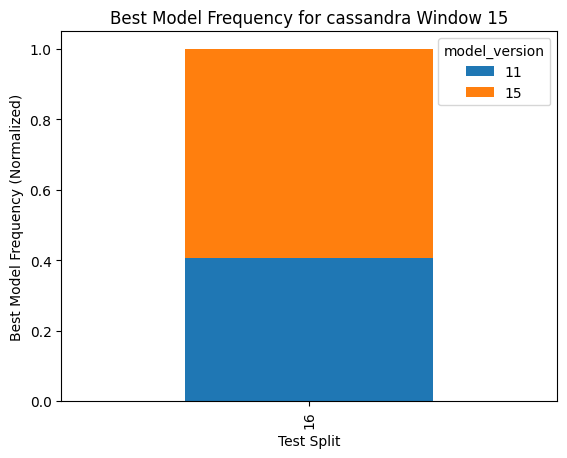

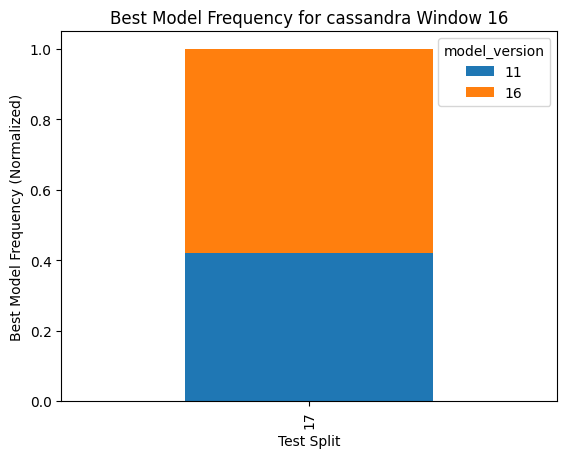

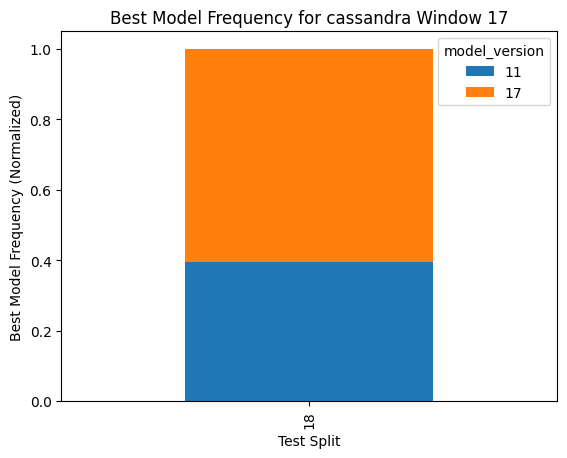

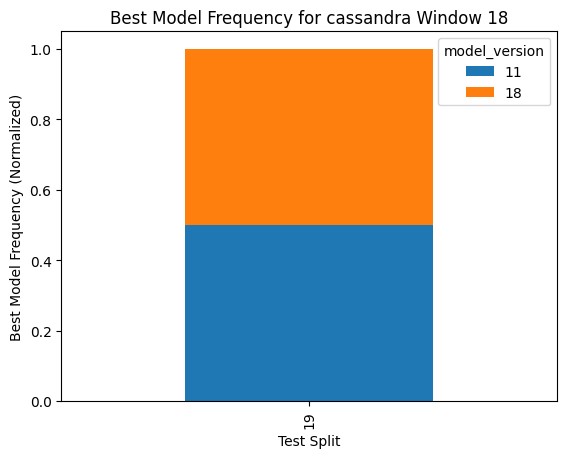

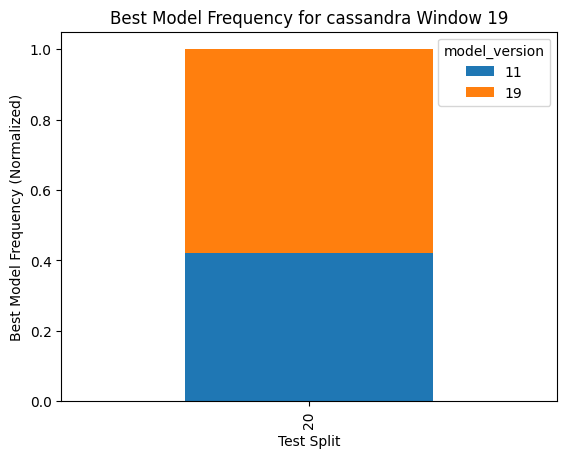

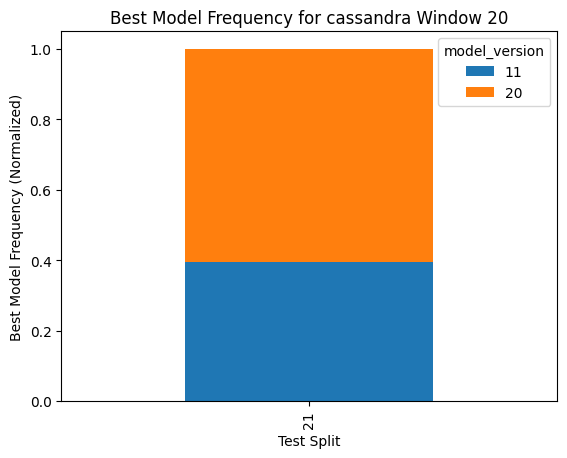

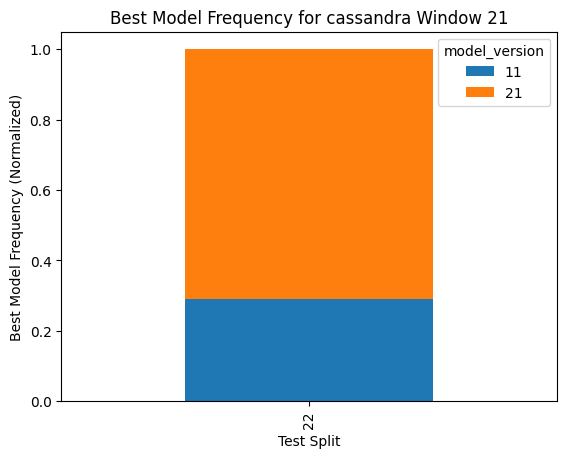

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")